In [ ]:
#camera calibration
import os
import numpy as np
import cv2
import glob
import matplotlib.image as mpimg
#matplotlib.use('qt5agg')
import matplotlib.pyplot as plt
import pickle
%matplotlib inline
#%matplotlib qt
#out_dir='output_images/stage0/'
# Make a list of calibration images
#img = glob.glob('camera_cal/calibration1.jpg')
#img = mpimg.imread('./camera_cal/calibration2.jpg')
#plt.imshow(img)

In [ ]:
#Saving objpoints and imgpoints to pickle
objpoints = []
imgpoints = []
images=glob.glob('./camera_cal/calibration*.jpg')

objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
    #print(ret)
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
    
    
    # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #plt.imshow(img)
with open("Calb_pts.pickle", "wb") as f:
    pickle.dump(imgpoints, f)
    pickle.dump(objpoints, f)
print('Calibaration Points Saved')    

In [ ]:
import os
import numpy as np
import cv2
import glob
import matplotlib.image as mpimg
#matplotlib.use('qt5agg')
#import matplotlib.pyplot as plt
import pickle
%matplotlib inline
#from ipywidgets import interact, interactive, fixed

In [ ]:
def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera and cv2.undistort()
    #undist = np.copy(img)  # Delete this line
    # Test undistortion on an image
    img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    #cv2.imwrite('test_undist.jpg',dst)
    return undist
###Example Undistorted Image


In [ ]:
# Class for perspective transforms
class Pers_Trans():
    def __init__(self):
        src = np.float32([[582,460],[203, 720],[1127, 720],[705,460]])
        dst = np.float32([[320,0],[320,720],[960,720],[960,0]])
    
        
        self.Mpersp = cv2.getPerspectiveTransform(src, dst)
        self.Minv = cv2.getPerspectiveTransform(dst, src)
        
    # Apply perspective transform
    def warp(self, img):
        return cv2.warpPerspective(img, self.Mpersp, (img.shape[1], img.shape[0]))
    
    # Reverse perspective transform
    def unwarp(self, img):
        return cv2.warpPerspective(img, self.Minv, (img.shape[1], img.shape[0]))

In [111]:
def combined_sobel_hsv(image):

    def abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(0, 255)):
            # Apply the following steps to img
    # 1) Convert to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
        if orient == 'x':
            sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
        else:
            sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
        abs_sobel = np.absolute(sobel)     
    # 3) Take the absolute value of the derivative or gradient
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
        scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
        thresh_min = thresh[0]
        thresh_max = thresh[1]
        sbinary = np.zeros_like(scaled_sobel)
        sbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
              
    # 6) Return this mask as your binary_output image
        binary_output = np.copy(sbinary) # Remove this line
               
        return binary_output

    def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Calculate the magnitude 
        gradmag = np.sqrt(sobelx**2 + sobely**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
        scale_factor = np.max(gradmag)/255 
        gradmag = (gradmag/scale_factor).astype(np.uint8)
    # 5) Create a binary mask where mag thresholds are met
        thresh_min = mag_thresh[0]
        thresh_max = mag_thresh[1]
        binary_output = np.zeros_like(gradmag)
        binary_output[(gradmag >= thresh_min) & (gradmag <= thresh_max)] = 1
        return binary_output
        

    def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel)
        abs_sobelx = np.absolute(sobelx)
        abs_sobely = np.absolute(sobely)
        graddr = np.arctan2(abs_sobely, abs_sobelx)    
        thresh_min = thresh[0]
        thresh_max = thresh[1]    
        sbinary = np.zeros_like(graddr)
        sbinary[(graddr >= thresh_min) & (graddr <= thresh_max)] = 1
        binary_output = np.copy(sbinary) # Remove this line
        return binary_output
# Choose a Sobel kernel size
    ksize = 3 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(20, 100))
    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(30, 100))
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.7, 1.3))
    combined = np.zeros_like(dir_binary)
##################################################
    #img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV).astype(np.float)
    #h_channel = hsv[:,:,1]
    h_channel = hsv[:,:,0]  
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    # Sobel x
    #s_thresh[0] = 170
    #s_thresh[1] = 255
    # Threshold color channel
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= 20) & (scaled_sobel <= 100)] = 1
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= 170) & (s_channel <= 255)] = 1
    
    R = image[:,:,0]
    G = image[:,:,1]
    B = image[:,:,2]
    threshr = (200, 255)
    r_binary = np.zeros_like(R)
    r_binary[(R > threshr[0]) & (R <= threshr[1])] = 1
################################################

    #hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    #H = hls[:,:,0]
    #L = hls[:,:,1]
    #S = hls[:,:,2]
    thresh = (10, 100)
    hbinary = np.zeros_like(h_channel)
    hbinary[(h_channel > thresh[0]) & (h_channel <= thresh[1])] = 1
    
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    thresh = (10, 100)
    hhbinary = np.zeros_like(H)
    hhbinary[(H > thresh[0]) & (H <= thresh[1])] = 1
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | ((s_binary == 1) & (sxbinary == 1)) | (r_binary == 1)] = 1
    #combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))| ((mag_binary == 1)| ((mag_binary == 1) & (dir_binary == 1))] = 1
    #combined[((gradx == 1) & (grady == 1)) ] = 1
    #combined[((gradx == 1))] = 1
    return combined

In [112]:
def newpipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV).astype(np.float)
    #h_channel = hsv[:,:,1]
  
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    return color_binary
    


In [113]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
def get_poly(binary_warped):

# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
# Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
#out_img_temp = out_img
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
    #print(out_img.shape)
    #print(histogram.shape)
    midpoint = np.int(histogram.shape[0]/2)
    #print(midpoint)
    leftx_base = np.argmax(histogram[:midpoint])
    #print(leftx_base)
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
    nwindows = 9
# Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
# Set the width of the windows +/- margin
    margin = 100
# Set minimum number of pixels found to recenter window
    minpix = 50
# Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

# Step through the windows one by one
    for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
        out_img = cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        out_img = cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    #plt.imshow(out_img)
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    #plt.xlim(0, 1280)
    #plt.ylim(720, 0)
    return left_fit, right_fit

In [114]:
def rad_curvature(poly, mask):
    yscale = 30 / 720 
    xscale = 3.7 / 700 
    
    # Convert polynomial to set of points for refitting
    ploty = np.linspace(0, mask.shape[0]-1, mask.shape[0])
    fitx = poly[0] * ploty ** 2 + poly[1] * ploty + poly[2]
    
    # Fit new polynomial
    curve_fit = np.polyfit(ploty * yscale, fitx * xscale, 2)
    
    # Calculate curve radius
    rad = ((1 + (2 * curve_fit[0] * np.max(ploty) * yscale + curve_fit[1]) ** 2) ** 1.5) / np.absolute(2 * curve_fit[0])
    return rad

In [115]:
def overlay(left_filt, right_fit, original):
    # Draw lines from polynomials
    ploty = np.linspace(0, original.shape[0]-1, original.shape[0])
    left_filt = left_filt[0]*ploty**2 + left_filt[1]*ploty + left_filt[2]
    right_fit = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    pts_left = np.array([np.transpose(np.vstack([left_filt, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fit, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Create an overlay from the lane lines
    overlay = np.zeros_like(original).astype(np.uint8)
    cv2.fillPoly(overlay, np.int_([pts]), (0,255, 0))
    
    # Apply inverse transform to the overlay to plot it on the originalinal road
    overlay = transform.unwarp(overlay)
    
    # Add the overlay to the originalinal unwarped image
    result = cv2.addWeighted(original, 1, overlay, 0.3, 0)
    return result

In [116]:
# Find the offset of the car and the base of the lane lines
def find_offset(left_line, right_line):
    lane_w = 3.7  # metres
    h = 720  # height of image (index of image bottom)
    w = 1280 # width of image
    
    # Find the bottom pixel of the lane lines
    l_px = left_line[0] * h ** 2 + left_line[1] * h + left_line[2]
    r_px = right_line[0] * h ** 2 + right_line[1] * h + right_line[2]
    
    # Find the number of pixels per real metre
    scale = lane_w / np.abs(l_px - r_px)
    
    # Find the midpoint
    midpoint = np.mean([l_px, r_px])
    
    # Find the offset from the centre of the frame, and then multiply by scale
    offset = (w/2 - midpoint) * scale
    return offset

In [117]:
last_rad = None
last_l = None
last_r = None

# Function for video
def process_frame(img):
    global last_rad, last_l, last_r
    
    # Define weights for smoothing
    r_alpha = 0.05
    p_alpha = 0.25
    with open("Calb_pts.pickle", "rb") as f:
        imgpoints = pickle.load(f)
        objpoints = pickle.load(f)
    img = cal_undistort(img, objpoints, imgpoints)
    # Undistort the image using the camera calibration
    
    
    # Keep the untransformed image for later
    original = img.copy()
    #
    # Apply perspective transform to the image
    img = transform.warp(img)
    
    # Apply the HLS/Sobel mask to detect lane pixels
    threshold = combined_sobel_hsv(img)
    #threshold = newpipeline(img)
    #newpipeline
    # Find initial histogram peaks
    #left_peak, right_peak = initial_position(threshold)
    
    # Get the sliding window polynomials for each line line
    left_line, right_line = get_poly(threshold)
    #poly_plot(threshold)
    # Update polynomials using weighted average with last frame
    if last_l is None:
        # for first frame, 
        last_l = left_line
        last_r = right_line
    else:
        
        left_line = (1 - p_alpha) * last_l + p_alpha * left_line
        right_line = (1 - p_alpha) * last_r + p_alpha * right_line
        last_l = left_line
        last_r = right_line
        
        # Calculate the lane curvature radius
    l_rad = rad_curvature(last_l, threshold)
    r_rad = rad_curvature(last_r, threshold)    
    
        # Get mean of curvatures
    rad = np.mean([l_rad, r_rad])
    
        # Update curvature using weighted average with last frame
    if last_rad is None:
        last_rad = rad
    else:
        last_rad = (1 - r_alpha) * last_rad + r_alpha * rad
        
    # Create image
    final = overlay(left_line, right_line, original)
    
        # Write radius on image
    cv2.putText(final, 'Curavture Radius: {}m'.format(int(last_rad)), (10, 50), cv2.FONT_HERSHEY_DUPLEX, 1.5, 255)
    
    # Write lane offset on image
    offset = find_offset(left_line, right_line)
    cv2.putText(final, 'Offset From Center: {}m'.format(round(offset, 4)), (10, 100), cv2.FONT_HERSHEY_DUPLEX, 1.5, 255)
    
        

    
    return final


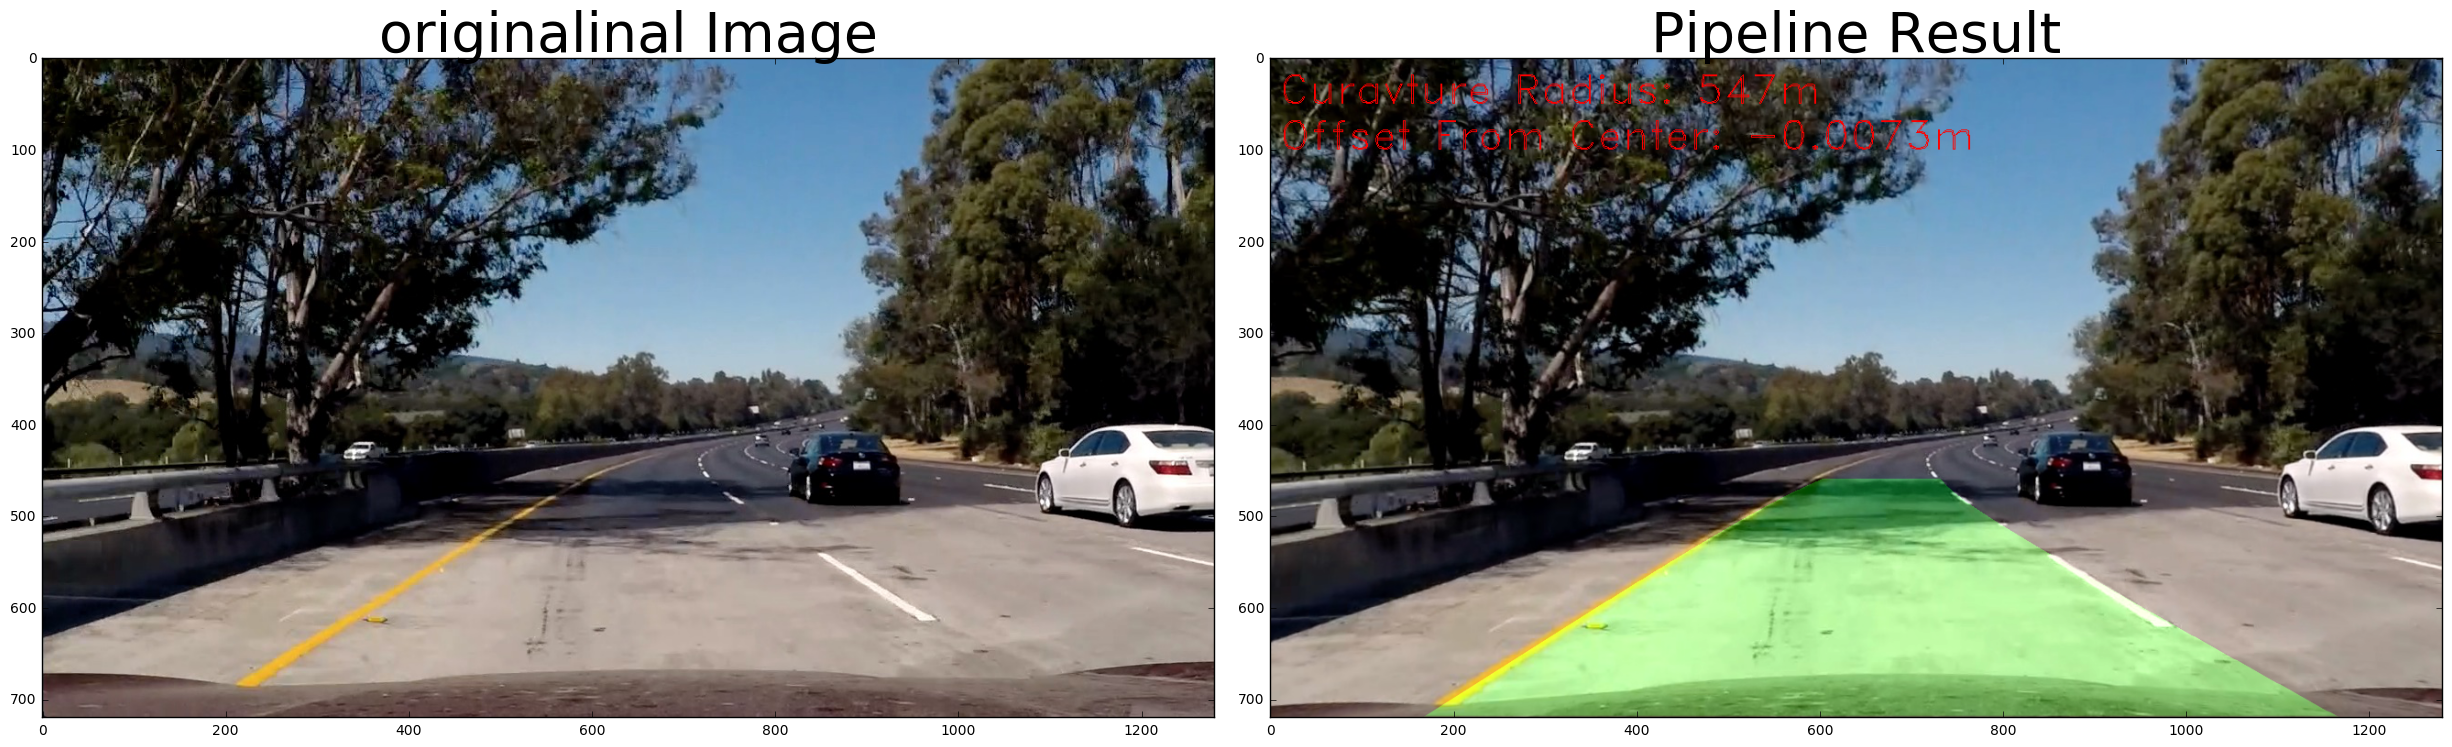

In [118]:
img = mpimg.imread('./test_images/test5.jpg')
transform = Pers_Trans()

result = process_frame(img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('originalinal Image', fontsize=40)
ax2.imshow(result, cmap='gray')
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)





In [121]:
from moviepy.editor import VideoFileClip

white_output = 'project_video_out.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_frame) #NOTE: this function expects color images!!

%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████████████████████████████████▉| 1260/1261 [36:57<00:01,  1.74s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

Wall time: 37min
